In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using StatsBase
using Alert

In [2]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64,η::Float64,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(η*sqrt(Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [3]:
function eigenR(n::Int64,Δt::Float64,K::Array{Float64,1},T::Array{Float64,1}) 
    R=diagm(0 =>ones(3)) #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n            #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(3))+diagm(1 => [K[i],T[i]]*Δt,-1 => -[K[i],T[i]]*Δt)+(0.5*diagm(1 => [K[i],T[i]]*Δt,-1 => -[K[i],T[i]]*Δt)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    R #Obtenemos el eigenvalor y eigenvector
end

eigenR (generic function with 1 method)

In [4]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)]
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2)

cos_2(x)=1-x^2/8
ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w))
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2)
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w))
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [5]:
MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [6]:
function Trayectoria(Δt::Float64,t::AbstractArray,ω::Array{Array{Float64,1},1},Ψ::Array{Float64,1})
    #T=ones(2001)*5
    #K=ones(2001)*5

    #T_v0=(eigen2(2,K,T,Δt).vectors)[:,1]      #Es el vector tangente inicial
    #N_v0=(eigen2(2,K,T,Δt).vectors)[:,2]*im   #Es el vector tangente inicial
    #B_v0=(eigen2(2,K,T,Δt).vectors)[:,3]      #Es el vector tangente inicial
    T_v0=[1.0,0.0,0.0]     #Es el vector tangente inicial
    N_v0=[0.0,1.0,0.0]   #Es el vector tangente inicial
    B_v0=[0.0,0.0,1.0]      #Es el vector tangente inicial
    ##########################################
    T_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    N_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    B_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    for i=1:length(t)                 #For que dura todos los pasos de tiempo
        T_v1=MatRot(ω[i],Ψ[i])*T_v0      #Genera todos los vecotres tangentes a partir del inicial
        N_v1=MatRot(ω[i],Ψ[i])*N_v0      #Genera todos los vecotres tangentes a partir del inicial
        B_v1=MatRot(ω[i],Ψ[i])*B_v0      #Genera todos los vecotres tangentes a partir del inicial
        push!(T_v,real(T_v1))    #Coloca los vectores tangentes en una lista
        push!(N_v,real(N_v1))    #Coloca los vectores tangentes en una lista
        push!(B_v,real(B_v1))    #Coloca los vectores tangentes en una lista
    end
    T_v=transpose(hcat(T_v...))     #Transforma T en algo mejor
    N_v=transpose(hcat(N_v...))     #Transforma N en algo mejor
    B_v=transpose(hcat(B_v...))     #Transforma B en algo mejor
    ##########################################
    Tx=T_v[:,1]
    Ty=T_v[:,2]
    Tz=T_v[:,3]
    ##########################################
    rx=Float64[]
    ry=Float64[]
    rz=Float64[]
    r1x=0.0
    r1y=0.0
    r1z=0.0
    for i=1:length(t)
        r1x=Tx[i]*Δt+r1x
        r1y=Ty[i]*Δt+r1y
        r1z=Tz[i]*Δt+r1z
        push!(rx,r1x)
        push!(ry,r1y)
        push!(rz,r1z)
    end
    r=[rx,ry,rz]
    T=[Tx,Ty,Tz]
    N=[N_v[:,1],N_v[:,2],N_v[:,3]]
    B=[B_v[:,1],B_v[:,2],B_v[:,3]]
    return r,T,N,B
end



Trayectoria (generic function with 1 method)

In [29]:
k0=0.01
t0=0.01

γK=2.0
γT=2.0

ηK=1.0
ηT=1.0

N=20.0

Δt=0.001

t=0:Δt:N

ctek=3.0
ctet=3.0


3.0

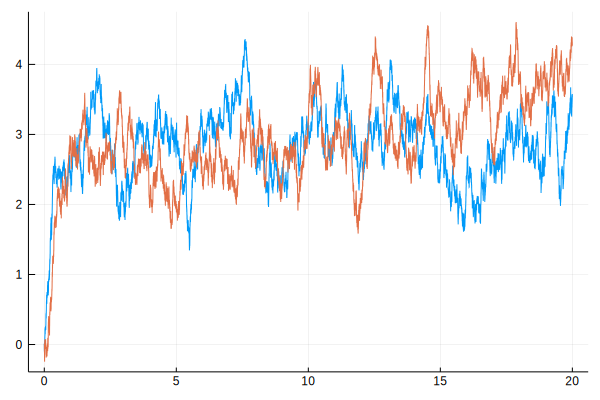

In [30]:
K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [31]:
function Trayectoria_qua(K::AbstractArray,T::AbstractArray,t::AbstractArray,Δt::Float64)
    Un=U.(K,T)
    ϕn=ϕ.(K,T,Δt)
    PASO=length(t)

    ω=Array{Array{Float64,1},1}(undef,PASO)
    Ψ=Array{Float64,1}(undef,PASO)
    ω[1]=Un[1]
    Ψ[1]=ϕn[1]

    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w
    Ψ[2]=ψ1
    for i=3:PASO
        ψ=ψn(ψ1,ϕn[i],Un[i],w)
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
        ω[i]=w
        Ψ[i]=ψ1
        ψ1=ψ
    end
    
    r,Tm,Nm,Bm=Trayectoria(Δt,t,ω,Ψ)
    
    return r,Tm,Nm,Bm
end

Trayectoria_qua (generic function with 1 method)

In [32]:
@time r,Tm,Nm,Bm=Trayectoria_qua(K,T,t,Δt);

  0.150923 seconds (1.19 M allocations: 46.401 MiB)


In [33]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(r[1],r[2],r[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(r[1],r[2],legend=false,title="XY")
P3=plot(r[1],r[3],legend=false,title="XZ")
P4=plot(r[2],r[3],legend=false,title="YZ")
plot(P1,P2,P3,P4,layout=l)
savefig("./Trayectorias_3D/Trayectoria_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).png")

In [12]:
plot(Tm[1],Tm[2],Tm[3], legend=false)
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Tm[1],Tm[2],Tm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Tm[1],Tm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Tm[1],Tm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Tm[2],Tm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l);

In [13]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Nm[1],Nm[2],Nm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Nm[1],Nm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Nm[1],Nm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Nm[2],Nm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l);


In [14]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Bm[1],Bm[2],Bm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Bm[1],Bm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Bm[1],Bm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Bm[2],Bm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l);

In [18]:
function eigenf(tiradas::Int64,PASO::Int64)


    θ=Array{Float64,1}(undef,tiradas)

    for j=1:tiradas

        K=OUH(k0,γK,t[1:PASO],Δt,ηK,ctek)
        T=OUH(t0,γT,t[1:PASO],Δt,ηT,ctet)

        Un=U.(K,T)
        ϕn=ϕ.(K,T,Δt)

        ω=Array{Array{Float64,1},1}(undef,PASO)
        Ψ=Array{Float64,1}(undef,PASO)
        ω[1]=Un[1]
        Ψ[1]=ϕn[1]

        ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
        w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
            w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
            w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
        ω[2]=w
        Ψ[2]=ψ1
        for i=3:PASO
            ψ=ψn(ψ1,ϕn[i],Un[i],w)
            w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
            ω[i]=w
            Ψ[i]=ψ1
            ψ1=ψ
        end
        θ[j]=Ψ[end]
    end
    return θ
end

eigenf (generic function with 1 method)

In [37]:
tiradas=10000
PASO=length(t)


20001

In [38]:
@time θ = eigenf(tiradas,PASO);

503.960117 seconds (4.37 G allocations: 118.767 GiB, 2.24% gc time)


In [39]:
Sp=vcat(θ,-θ,zeros(length(θ)))
Sp=angle.(exp.(-im*Sp))

30000-element Array{Float64,1}:
  1.945119936682689 
  0.7978415613625451
  1.6891928478957934
  0.8853609717598865
  3.1016372247396533
  2.492607898493066 
 -2.0231973867022544
  1.6222646114375494
  1.1188101505503314
  3.0069531960540825
  1.533461384505886 
  2.9477027030103464
  2.385698700794938 
  ⋮                 
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               

In [40]:
@time begin  
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(exp.(-im*Sp)),imag(exp.(-im*Sp)),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="Eigenvalores")
Q2=histogram(real(exp.(-im*Sp)),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(exp.(-im*Sp)),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(Sp,normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfases")
plot(Q1,Q2,Q3,Q4,layout=l)
savefig("Eigenvalores_Completo_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).png");
end

  0.247274 seconds (526.32 k allocations: 29.934 MiB)


In [41]:
step=100
tiradas=500
a=2:step:length(t)

2:100:19902

2499.694526 seconds (21.62 G allocations: 589.881 GiB, 2.39% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\sebas\Desktop\tesis\Animacion_Prueba_3D_gamK=2.0_gam=2.0_etaK=1.0_etaT=1.0_k0=0.01_t0=0.01_ck=_3.0ct=3.0.gif
└ @ Plots C:\Users\sebas\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\sebas\\Desktop\\tesis\\Animacion_Prueba_3D_gamK=2.0_gam=2.0_etaK=1.0_etaT=1.0_k0=0.01_t0=0.01_ck=_3.0ct=3.0.gif")
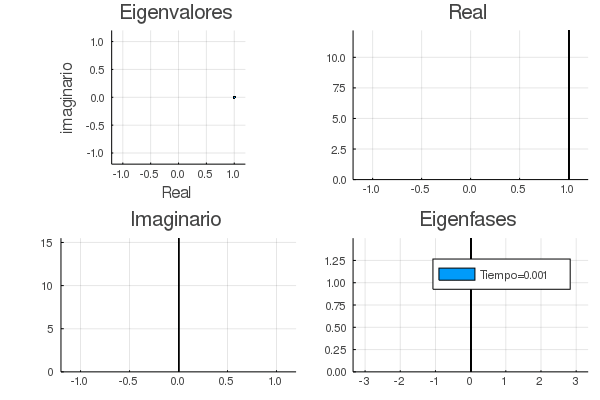

In [42]:
@time begin    
    anim= @animate for j=2:step:length(t)
        θ = eigenf(tiradas,j);
        Sp=vcat(θ,-θ,zeros(length(θ)))
        Sp=angle.(exp.(-im*Sp))
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q1=scatter(real(exp.(-im*Sp)),imag(exp.(-im*Sp)),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="Eigenvalores",xlims=(-1.2,1.2),ylims=(-1.2,1.2))
        Q2=histogram(real(exp.(-im*Sp)),normalized=true,title="Real",legend=false,bins=100,xlims=(-1.2,1.2),ylims=(0,12.2))
        Q3=histogram(imag(exp.(-im*Sp)),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-1.2,1.2),ylims=(0,15.5))
        Q4=histogram(Sp,normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfases",xlims=(-(1*π+0.2),1*π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).gif", fps=60)
end